In [106]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
sns.set(style="white")

## Looking at Amenity Count vs. Price
### Goals for this step:
- normalize Price data per country 
        Airbnb Price / Price Mean per Country
- explore the data using line graphs for different countries
- create a linear regression model that models all countries

In [142]:
df = pd.read_pickle("../../Datasets/Data_viz_project/airbnb_listings_countries.pkl")

### Create a column with the normalized prices
Because of the size of the table, we needed to do this step country by country 

In [154]:
df.head()

,Listing ID,Name,Host ID,Host Name,Host Response Rate,Host Is Superhost,Host total listings count,Country,latitude,longitude,...,Review Scores Accuracy,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Reviews per month,Amenity_Count,Country_Average,Normalized
0,5534229,A 2 Passi da San Pietro,28697142,Veronica,100.0,False,5.0,Italy,41.895878,12.454430,...,9.0,10.0,8.0,8.0,9.0,9.0,0.08,11,91.322033,0.810319
1,5903406,cosy small apartment,1853799,Veronika,88.0,False,2.0,Austria,48.246033,16.340743,...,9.0,10.0,10.0,10.0,10.0,8.0,0.27,12,65.071831,0.845220
2,5203533,Rummelig lejl i hjertet af KBH,24801534,Marianne,100.0,False,1.0,Denmark,55.681579,12.562770,...,10.0,10.0,10.0,10.0,10.0,10.0,0.28,8,599.040734,1.657650
3,8858475,Modern; spacious and warm; with its own balcony,3000397,Lasse,100.0,True,1.0,Denmark,55.708413,12.596737,...,10.0,10.0,10.0,10.0,9.0,10.0,0.79,23,599.040734,1.163527
4,4215511,Nice room; Bohemian Cph; N�rrebro,126020,Lea,100.0,True,2.0,Denmark,55.687506,12.558365,...,10.0,10.0,9.0,10.0,10.0,10.0,1.40,10,599.040734,0.707798


In [144]:
df = df.assign(Country_Average=df.groupby("Country")["Price"].transform("mean"))

In [145]:
df = df.assign(Normalized=df["Price"]/df["Country_Average"])

In [146]:
df.to_pickle("../../Datasets/Data_viz_project/airbnb_listings_price_normalized")

### Select only the columns we want to look at

In [162]:
df.columns

Index(['Listing ID', 'Name', 'Host ID', 'Host Name', 'Host Response Rate',
       'Host Is Superhost', 'Host total listings count', 'Country', 'latitude',
       'longitude', 'Property type', 'Room type', 'Accommodates', 'Bathrooms',
       'Bedrooms', 'Amenities', 'Price', 'Minimum nights', 'Maximum nights',
       'Availability 365', 'Calendar last scraped', 'Number of reviews',
       'Last Review Date', 'Review Scores Rating', 'Review Scores Accuracy',
       'Review Scores Cleanliness', 'Review Scores Checkin',
       'Review Scores Communication', 'Review Scores Location',
       'Review Scores Value', 'Reviews per month', 'Amenity_Count',
       'Country_Average', 'Normalized'],
      dtype='object')

In [167]:
df_select = df[["Listing ID", "Price", "Country",  "Amenity_Count", "Country_Average", "Normalized"]].copy()

In [168]:
df_select

,Listing ID,Price,Country,Amenity_Count,Country_Average,Normalized
0,5534229,74.0,Italy,11,91.322033,0.810319
1,5903406,55.0,Austria,12,65.071831,0.845220
2,5203533,993.0,Denmark,8,599.040734,1.657650
3,8858475,697.0,Denmark,23,599.040734,1.163527
4,4215511,424.0,Denmark,10,599.040734,0.707798
...,...,...,...,...,...,...
380219,20810636,150.0,United States,24,147.752527,1.015211
380220,9563852,35.0,France,9,92.502003,0.378370
380221,5841088,110.0,Australia,16,158.146457,0.695558
380222,12157261,69.0,Canada,13,112.839815,0.611486


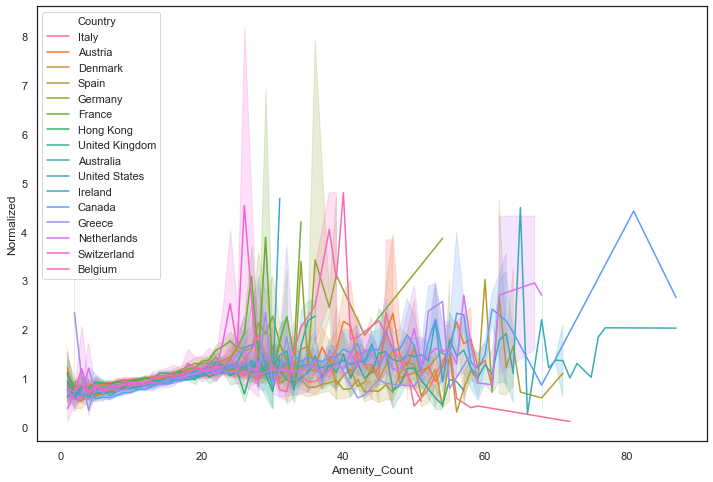

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(data=df_select,
                 x="Amenity_Count",
                 y="Normalized",
                 hue="Country")

### Choosing Quantile to focus on
As a group, we chose to remove the outliers and to focus on 97.5% of the data, which have 30 or less amenities

In [148]:
df_select["Amenity_Count"].quantile(.975)

30.0

In [170]:
df_30 = df_select.loc[df_select["Amenity_Count"]<=30].copy()

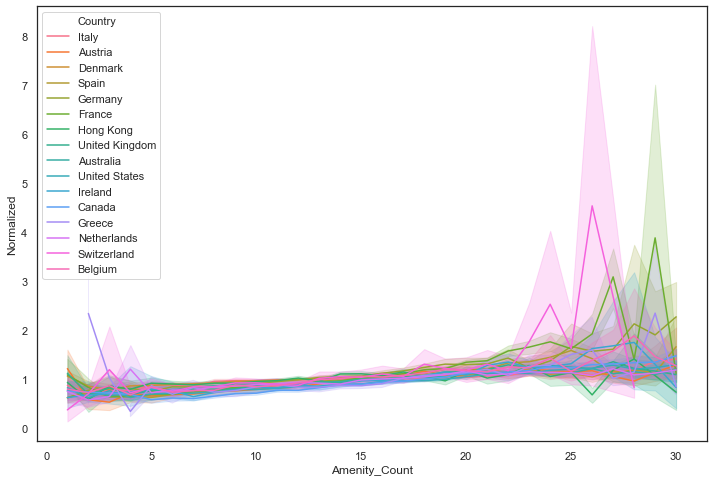

In [171]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized",
                 hue="Country")

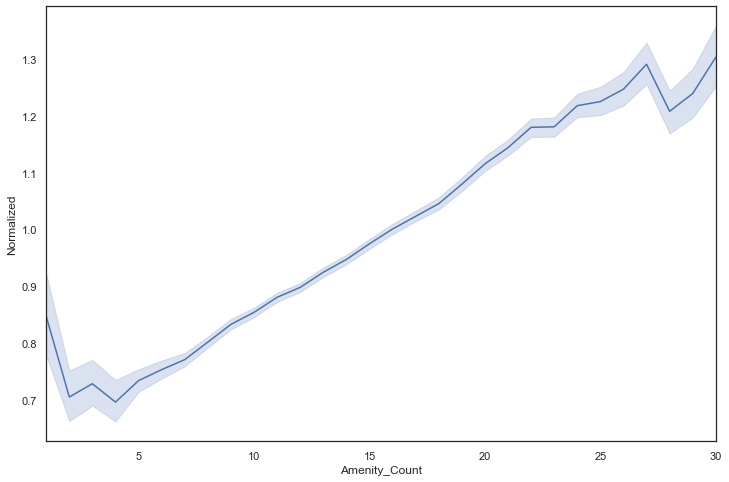

In [151]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.lineplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
ax.set_xlim([1,30]);

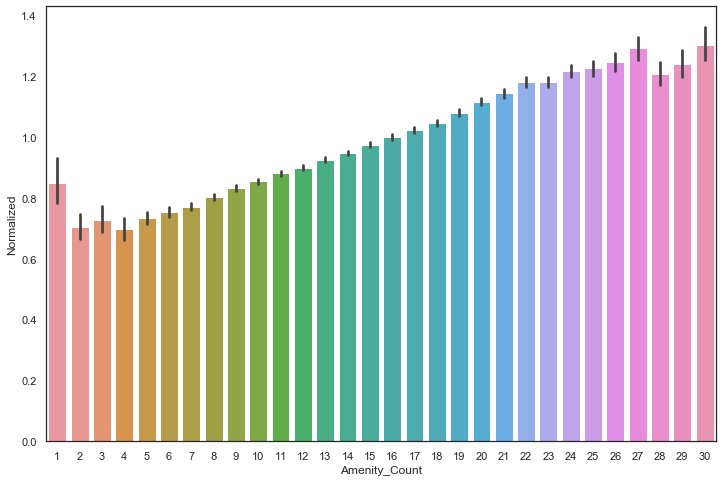

In [152]:
fig, ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized");

### Looking at the graph above, we wanted to create a linear regression model that could help predict how many amenities people would need in order to charge the price they wanted
Steps:
1. use statsmodels OLS to try to find the correct regression model


In [172]:
df_30["Const"] = 1

In [157]:
X = df_30[["Amenity_Count", "Const"]]
y = df_30["Normalized"]

In [173]:
model = sm.OLS(y, X).fit()
result = model.predict(X)
df_30["Pred_1"] = result

In [174]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Normalized   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:24:25   Log-Likelihood:            -4.2670e+05
No. Observations:              371013   AIC:                         8.534e+05
Df Residuals:                  371011   BIC:                         8.534e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Amenity_Count     0.0247      0.000    104.106      0.000       0.024       0.025
Const             0.6072      0.004    155.294      0.000       0.600       0.615
==============================================================================
Omnibus:                   276277.544   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7221191.296
Skew:                           3.352   Prob(JB):                         0.00
Kurtosis:                      23.547   Cond. No.                         51.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

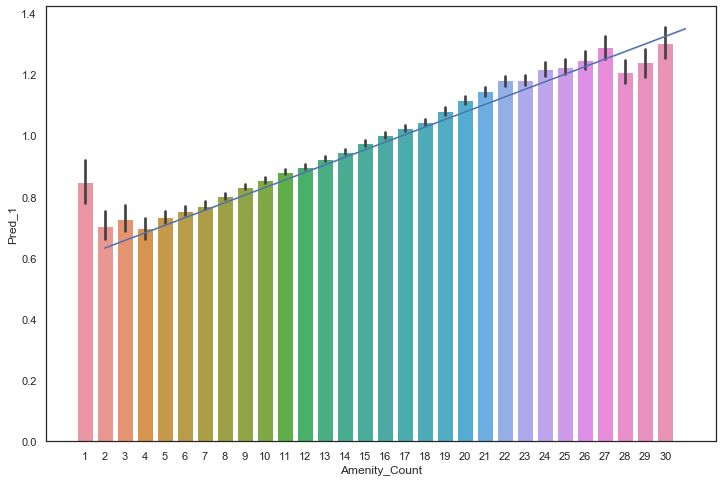

In [177]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
sns.lineplot(data=df_30,
            x="Amenity_Count", 
            y="Pred_1",
            ax=ax);

Looking at the R score and visualization of this regression, we deicde this is not the best fit. We are going to try polynomial regression instead 

In [185]:
df_30["AC2"] = df_30["Amenity_Count"]*df_30["Amenity_Count"]

In [186]:
X2 = df_30[["AC2", "Amenity_Count", "Const"]]
y2 = df_30["Normalized"]

model2 = sm.OLS(y2, X2).fit()
result2 = model2.predict(X2)
df_30["Pred_2"] = result2

In [187]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Normalized   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     5419.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:40:56   Log-Likelihood:            -4.2670e+05
No. Observations:              371013   AIC:                         8.534e+05
Df Residuals:                  371010   BIC:                         8.534e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
AC2           -3.056e-05    3.5e-05     -0.872      0.383   -9.92e-05    3.81e-05
Amenity_Count     0.0257      0.001     22.203      0.000       0.023       0.028
Const             0.6000      0.009     66.104      0.000       0.582       0.618
==============================================================================
Omnibus:                   276294.987   Durbin-Watson:                   1.737
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7222761.587
Skew:                           3.352   Prob(JB):                         0.00
Kurtosis:                      23.549   Cond. No.                     2.35e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

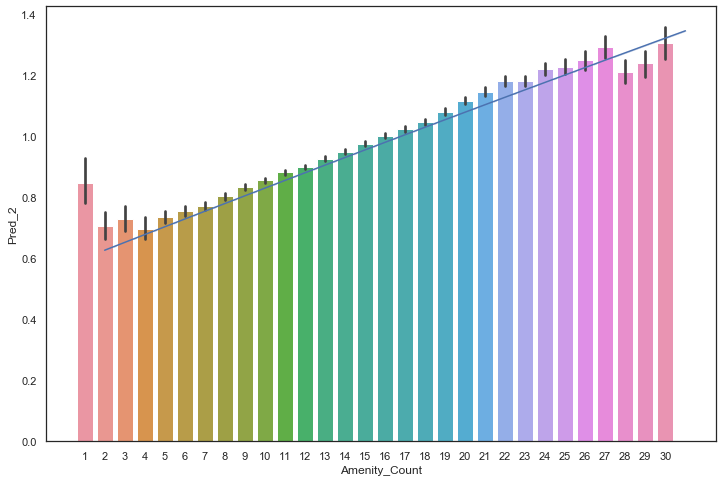

In [180]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
sns.lineplot(data=df_30,
            x="Amenity_Count", 
            y="Pred_2",
            ax=ax);

Looking at the R score and visualization of this regression, we deicde this is still not the best fit. We are going to try polynomial regression with a cubed value instead. 

In [188]:
df_30["AC3"] = df_30["Amenity_Count"]*df_30["Amenity_Count"]*df_30["Amenity_Count"]

In [190]:
X3 = df_30[["AC3", "AC2", "Amenity_Count", "Const"]]
y3 = df_30["Normalized"]

model3 = sm.OLS(y3, X3).fit()
result3 = model3.predict(X3)
df_30["Pred_3"] = result3

In [191]:
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Normalized   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     3636.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:41:40   Log-Likelihood:            -4.2667e+05
No. Observations:              371013   AIC:                         8.533e+05
Df Residuals:                  371009   BIC:                         8.534e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
AC3           -3.823e-05   4.62e-06     -8.278      0.000   -4.73e-05   -2.92e-05
AC2               0.0018      0.000      8.046      0.000       0.001       0.002
Amenity_Count    -0.0018      0.004     -0.511      0.609      -0.009       0.005
Const             0.7196      0.017     42.181      0.000       0.686       0.753
==============================================================================
Omnibus:                   276258.983   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7221104.383
Skew:                           3.352   Prob(JB):                         0.00
Kurtosis:                      23.547   Cond. No.                     9.81e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.81e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

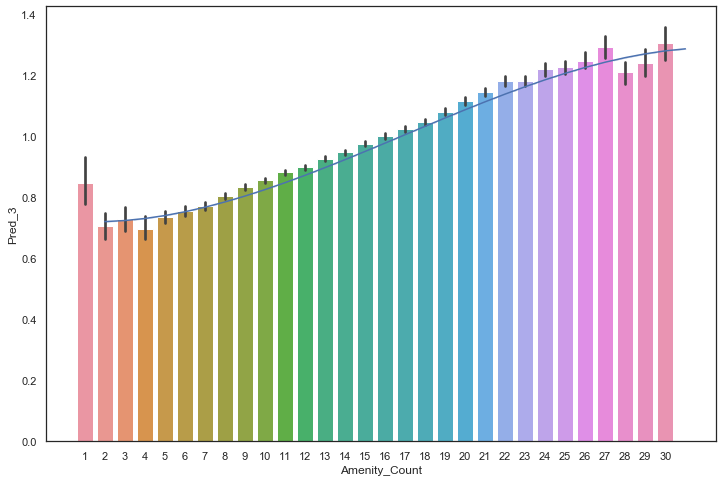

In [192]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
sns.lineplot(data=df_30,
            x="Amenity_Count", 
            y="Pred_3",
            ax=ax);

In [206]:
df_30["AC4"] = df_30["Amenity_Count"]*df_30["Amenity_Count"]*df_30["Amenity_Count"]*df_30["Amenity_Count"]

In [214]:
X4 = df_30[["AC4", "AC3", "AC2", "Amenity_Count", "Const"]]
y4 = df_30["Normalized"]

model4 = sm.OLS(y4, X4).fit()
result4 = model4.predict(X4)
df_30["Pred_4"] = result4

In [215]:
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Normalized   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2729.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:55:18   Log-Likelihood:            -4.2667e+05
No. Observations:              371013   AIC:                         8.533e+05
Df Residuals:                  371008   BIC:                         8.534e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
AC4           -1.322e-06   5.92e-07     -2.233      0.026   -2.48e-06   -1.62e-07
AC3            4.682e-05   3.84e-05      1.220      0.222   -2.84e-05       0.000
AC2           -4.158e-05      0.001     -0.048      0.962      -0.002       0.002
Amenity_Count     0.0146      0.008      1.794      0.073      -0.001       0.031
Const             0.6732      0.027     25.048      0.000       0.621       0.726
==============================================================================
Omnibus:                   276256.890   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7221002.405
Skew:                           3.352   Prob(JB):                         0.00
Kurtosis:                      23.547   Cond. No.                     3.75e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.75e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

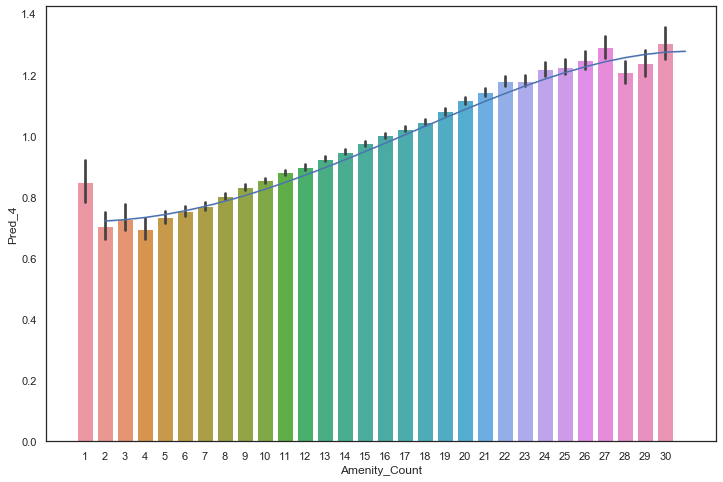

In [213]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
sns.lineplot(data=df_30,
            x="Amenity_Count", 
            y="Pred_4",
            ax=ax);

Although we are getting closer and close to idea p-values for all variables, we decided to do one more regression to see if the R or F values improve.

In [216]:
df_30["AC5"] = (df_30["Amenity_Count"]
                *df_30["Amenity_Count"]
                *df_30["Amenity_Count"]
                *df_30["Amenity_Count"]
                *df_30["Amenity_Count"])

In [217]:
X5 = df_30[["AC5", "AC4", "AC3", "AC2", "Amenity_Count", "Const"]]
y5 = df_30["Normalized"]

model5 = sm.OLS(y5, X5).fit()
result5 = model5.predict(X5)
df_30["Pred_5"] = result5

model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Normalized   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     2185.
Date:                Tue, 28 Apr 2020   Prob (F-statistic):               0.00
Time:                        12:59:33   Log-Likelihood:            -4.2666e+05
No. Observations:              371013   AIC:                         8.533e+05
Df Residuals:                  371007   BIC:                         8.534e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
AC5            -2.71e-07    7.8e-08     -3.475      0.001   -4.24e-07   -1.18e-07
AC4            2.023e-05   6.23e-06      3.247      0.001    8.02e-06    3.24e-05
AC3              -0.0006      0.000     -3.148      0.002      -0.001      -0.000
AC2               0.0084      0.003      3.253      0.001       0.003       0.013
Amenity_Count    -0.0342      0.016     -2.103      0.036      -0.066      -0.002
Const             0.7660      0.038     20.222      0.000       0.692       0.840
==============================================================================
Omnibus:                   276242.534   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7220343.175
Skew:                           3.351   Prob(JB):                         0.00
Kurtosis:                      23.546   Cond. No.                     1.38e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

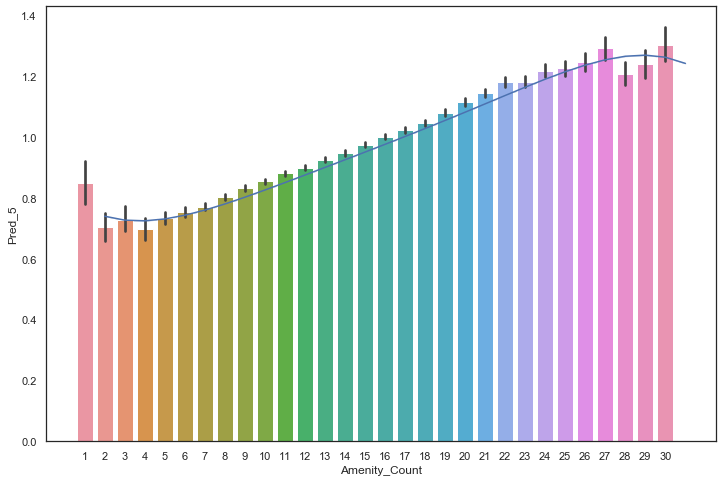

In [218]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(data=df_30,
                 x="Amenity_Count",
                 y="Normalized")
sns.lineplot(data=df_30,
            x="Amenity_Count", 
            y="Pred_5",
            ax=ax);